# Using a ML-like Loss Function

In the end one likely wants to combine optimizing cuts with a more traditional ML-like set of cuts. Instead of the $S/\sqrt{B}$ lets use the classification loss function that is more standard and see how that performs.

In [1]:
import jax
import jax.numpy as jnp
import numpy
import matplotlib.pyplot as plt
from samples import data_back, sig_avg, sig_width
from jax_helpers import erf

_ = plt.ion()

Create a complete array that has the values and the answers. The current signal and background samples aren't the same size. This just makes the loss function harder to see. So - lets create a signal sample that is as big as the background sample.

In [2]:
data_sig = numpy.random.normal(sig_avg, sig_width, len(data_back))

training_data = jnp.concatenate((data_back, data_sig))
training_truth = jnp.concatenate((jnp.zeros(len(data_back)), jnp.ones(len(data_sig))))

## Loss Function

A standard distance function:

In [3]:
def predict(c: float):
    'Predict if background or signal depending on the cut'
    return erf(training_data, c)

def loss(c: float):
    return jnp.sum((predict(c) - training_truth)**2)

In [4]:
cut_values = numpy.linspace(-10.0, 10.0, 100)
cut_loss = numpy.array([loss(c) for c in cut_values])

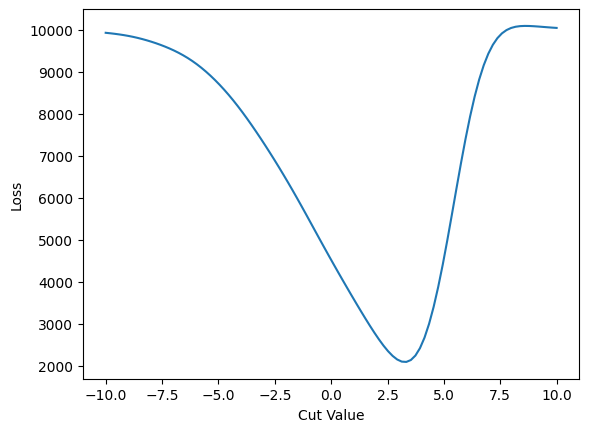

In [5]:
plt.plot(cut_values, cut_loss)
plt.xlabel('Cut Value')
plt.ylabel(r'Loss')
# plt.axvline(cut_values[max_index], color='green')
# plt.text(cut_values[max_index]+0.2, s_sqrt_b[max_index]/2.0, f'{cut_values[max_index]:0.3}', rotation=90)
plt.show()

## Gradient

Look at the gradient of that function now

In [6]:
grad = jax.grad(loss)

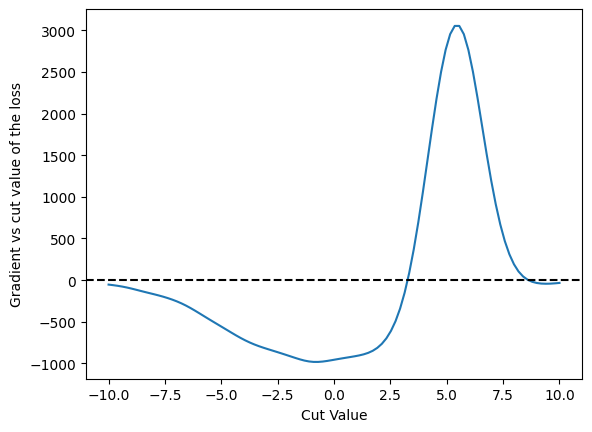

In [7]:
plt.plot(cut_values, numpy.array([grad(c) for c in cut_values]))
plt.xlabel('Cut Value')
plt.ylabel(r'Gradient vs cut value of the loss')
plt.axhline(0.0, color='black', linestyle='dashed')
plt.show()

## Gradient Descent Loop

Repeat the learning using gradient descent

In [8]:
LEARNING_RATE = 0.0005

def update_cut(c: float):
    'Run one iteration of the loop, and return a new cut value'

    g_value = grad(c)
    return c - g_value * LEARNING_RATE

In [9]:
c = 0.0
values = []
losses = []
l = -1.0
# log the cuts for tracking values during training
# will get used in next chapter.
with open('_cut.log', 'w') as out:
    for count in range(0, 50):
        l = loss(c)
        values.append(c)
        losses.append(l)
        c = update_cut(c)
        out.write(f'{c}\n')
print(f'final cut is {c:0.3} with loss {l}')

final cut is 3.26 with loss 2082.857177734375


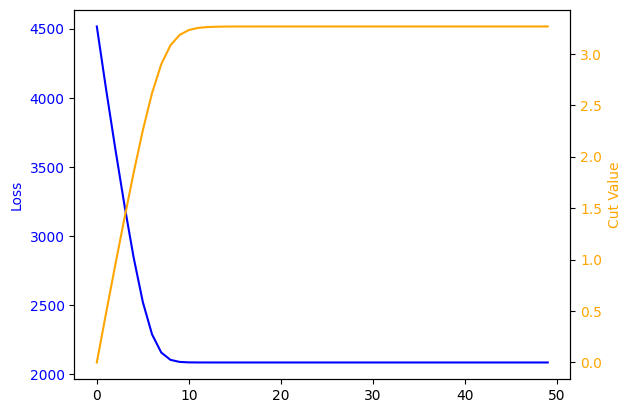

In [10]:
fig, ax1 = plt.subplots() 

ax1.plot (range(0,len(losses)), losses, label=r'$S/\sqrt{B}$', color='blue')
ax1.set_ylabel(r'Loss', color='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Cut Value', color='orange')
ax2.plot (range(0, len(values)), values, label='Cut Value', color='orange')
ax2.tick_params(axis ='y', labelcolor = 'orange')
plt.xlabel('Training Iteration')
plt.show()

The `3.26` is close to the `3.62` that we found previously with $S/\sqrt{B}$. However, the loss function is much better behaved and we did not have to choose our starting point for the cut carefully at all!

In a real experiment, we'd use the final likelihood in order to determine this value rather than a simple loss function. However, this will do for the rest of experiments.